### Import Libraries

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Dataset Loading

In [75]:
# Load Dataset from github repository
df = pd.read_csv("spam.csv", encoding='ISO-8859-1')

### Dataset First View

In [76]:
# Dataset First Look
# View top 5 rows of the dataset
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Dataset Rows & Columns count

In [77]:
print("Number of rows are: ",df.shape[0])
print("Number of columns are: ",df.shape[1])

Number of rows are:  5572
Number of columns are:  5


### Dataset Information

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


#### Duplicate Values

In [79]:
dup = df.duplicated().sum()
print(f'number of duplicated rows are {dup}')

number of duplicated rows are 403


#### Missing Values/Null Values

In [80]:
df.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

## ***2. Understanding The Variables***

In [81]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [82]:
df.describe(include= 'all').round(2)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


### Check Unique Values for each variable.

In [83]:
for i in df.columns.tolist():
  print("No. of unique values in",i,"is",df[i].nunique())

No. of unique values in v1 is 2
No. of unique values in v2 is 5169
No. of unique values in Unnamed: 2 is 43
No. of unique values in Unnamed: 3 is 10
No. of unique values in Unnamed: 4 is 5


## ***3. Data Wrangling***

In [84]:
# Change the v1 & v2 columns as Category and Message
df.rename(columns={"v1": "Category", "v2": "Message"}, inplace=True)

In [85]:
# Removing the all unnamed columns (its include much number of missing values)
df.drop(columns={'Unnamed: 2','Unnamed: 3','Unnamed: 4'}, inplace=True)

In [86]:
# Create a binary 'Spam' column: 1 for 'spam' and 0 for 'ham', based on the 'Category' column.
df['Spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)

In [87]:
# Updated new dataset
df.head()

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## ***4. Exploratory Data Analysis (EDA)***

#### Chart - 1 : Distribution of Spam vs Ham

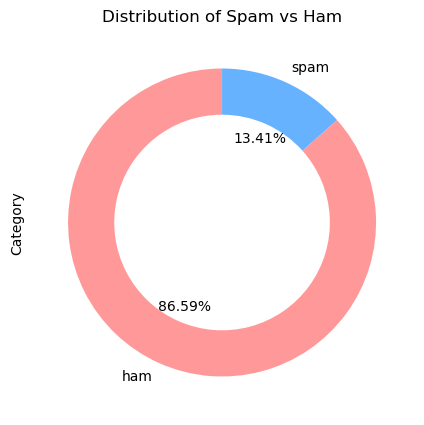

In [88]:
spread = df['Category'].value_counts()
plt.rcParams['figure.figsize'] = (5,5)

colors = ['#FF9999', '#66B2FF'] 
spread.plot(kind='pie', autopct='%1.2f%%', colors=colors, wedgeprops=dict(width=0.3), startangle=90)

plt.title('Distribution of Spam vs Ham')
plt.show()

#### Chart - 2 : Most Used Words in Spam Messages

In [89]:
# Splitting Spam Messages
df_spam = df[df['Category']=='spam'].copy()

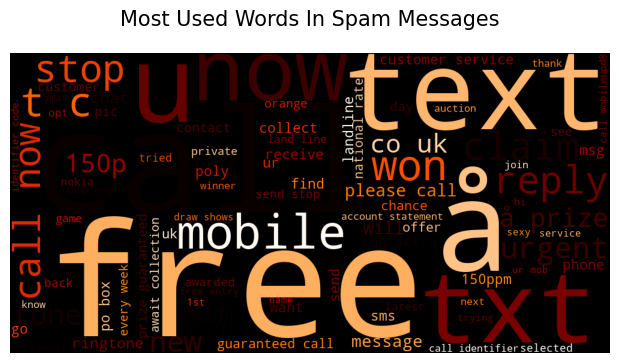

In [93]:
# Chart - 2 WordCloud Plot Visualization Code For Most Used Words in Spam Messages
# Create a String to Store All The Words
comment_words = ''

# Remove The Stopwords
stopwords = set(STOPWORDS)

# Iterate Through The Column
for val in df_spam.Message:

    # Typecaste Each Val to String
    val = str(val)

    # Split The Value
    tokens = val.split()

    # Converts Each Token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

# Set Parameters
wordcloud = WordCloud(width = 1000, height = 500,
                background_color ='black',
                stopwords = stopwords,
                min_font_size = 15,
                max_words = 500,
                colormap = 'gist_heat_r').generate(comment_words)

# Set Labels
plt.figure(figsize = (6,6), facecolor = None)
plt.title('Most Used Words In Spam Messages', fontsize = 15, pad=20)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

# Display Chart
plt.show()

## ***5. Feature Engineering & Data Pre-processing***

### Data Splitting

In [94]:
# Splitting the data to train and test
X_train,X_test,y_train,y_test=train_test_split(df.Message,df.Spam,test_size=0.25)

## ***6. ML Model Implementation***

In [100]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
  
    # fit the model on the training data
    model.fit(X_train, y_train)

    # make predictions on the test data
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_prob_train = model.predict_proba(X_train)[:,1]
    pred_prob_test = model.predict_proba(X_test)[:,1]

    # calculate ROC AUC score
    roc_auc_train = roc_auc_score(y_train, y_pred_train)
    roc_auc_test = roc_auc_score(y_test, y_pred_test)
    print("\nTrain ROC AUC:", roc_auc_train)
    print("Test ROC AUC:", roc_auc_test)

    # plot the ROC curve
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, pred_prob_train)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, pred_prob_test)
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr_train, tpr_train, label="Train ROC AUC: {:.2f}".format(roc_auc_train))
    plt.plot(fpr_test, tpr_test, label="Test ROC AUC: {:.2f}".format(roc_auc_test))
    plt.legend()
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

    # calculate confusion matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)

    fig, ax = plt.subplots(1, 2, figsize=(11,4))

    print("\nConfusion Matrix:")
    sns.heatmap(cm_train, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[0])
    ax[0].set_xlabel("Predicted Label")
    ax[0].set_ylabel("True Label")
    ax[0].set_title("Train Confusion Matrix")

    sns.heatmap(cm_test, annot=True, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], cmap="Oranges", fmt='.4g', ax=ax[1])
    ax[1].set_xlabel("Predicted Label")
    ax[1].set_ylabel("True Label")
    ax[1].set_title("Test Confusion Matrix")

    plt.tight_layout()
    plt.show()


    # calculate classification report
    cr_train = classification_report(y_train, y_pred_train, output_dict=True)
    cr_test = classification_report(y_test, y_pred_test, output_dict=True)
    print("\nTrain Classification Report:")
    crt = pd.DataFrame(cr_train).T
    print(crt.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_train).T.iloc[:, :-1], annot=True, cmap="Blues")
    print("\nTest Classification Report:")
    crt2 = pd.DataFrame(cr_test).T
    print(crt2.to_markdown())
    # sns.heatmap(pd.DataFrame(cr_test).T.iloc[:, :-1], annot=True, cmap="Blues")


    precision_train = cr_train['weighted avg']['precision']
    precision_test = cr_test['weighted avg']['precision']

    recall_train = cr_train['weighted avg']['recall']
    recall_test = cr_test['weighted avg']['recall']

    acc_train = accuracy_score(y_true = y_train, y_pred = y_pred_train)
    acc_test = accuracy_score(y_true = y_test, y_pred = y_pred_test)

    F1_train = cr_train['weighted avg']['f1-score']
    F1_test = cr_test['weighted avg']['f1-score']

    model_score = [precision_train, precision_test, recall_train, recall_test, acc_train, acc_test, roc_auc_train, roc_auc_test, F1_train, F1_test ]
    return model_score

### ML Model: Multinomial Naive Bayes

In [102]:
clf = Pipeline([
    ('vectorizer', CountVectorizer()),  # Step 1: Text data transformation
    ('nb', MultinomialNB())  # Step 2: Classification using Naive Bayes
])

#### Explain the ML Model used and it's performance using Evaluation metric Score Chart.


Train ROC AUC: 0.9852926014669976
Test ROC AUC: 0.9572012950080938


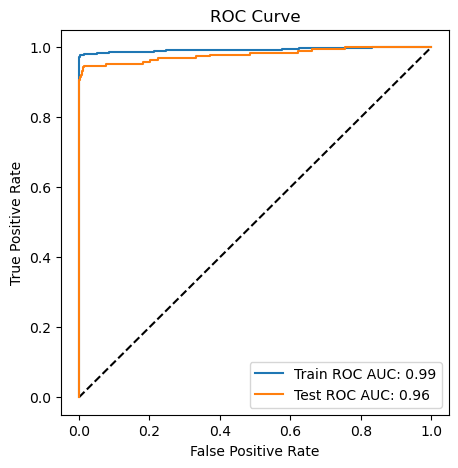


Confusion Matrix:


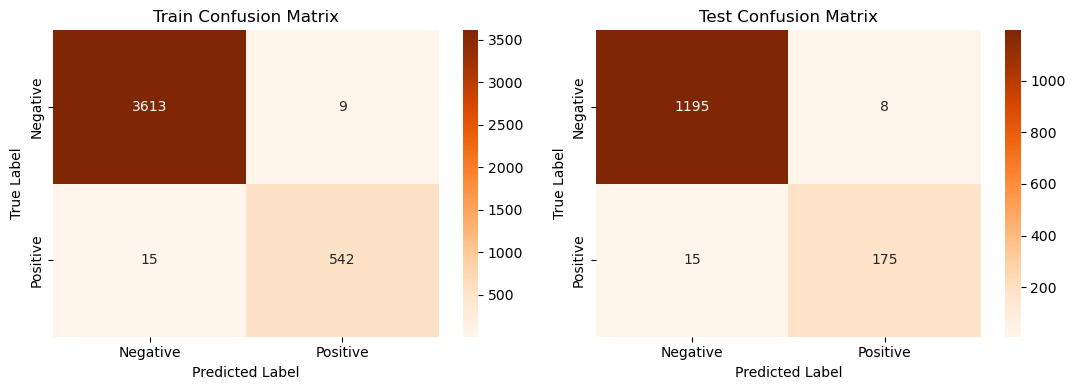


Train Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.995865 | 0.997515 |   0.99669  | 3622        |
| 1            |    0.983666 | 0.97307  |   0.978339 |  557        |
| accuracy     |    0.994257 | 0.994257 |   0.994257 |    0.994257 |
| macro avg    |    0.989766 | 0.985293 |   0.987515 | 4179        |
| weighted avg |    0.994239 | 0.994257 |   0.994244 | 4179        |

Test Classification Report:
|              |   precision |   recall |   f1-score |     support |
|:-------------|------------:|---------:|-----------:|------------:|
| 0            |    0.987603 | 0.99335  |   0.990468 | 1203        |
| 1            |    0.956284 | 0.921053 |   0.938338 |  190        |
| accuracy     |    0.983489 | 0.983489 |   0.983489 |    0.983489 |
| macro avg    |    0.971944 | 0.957201 |   0.964403 | 1393        |
| weighted avg |    0.983331 | 0.983489 |   

In [103]:
MultinomialNB_score = evaluate_model(clf, X_train, X_test, y_train, y_test)

## ***7. Email Spam Detection System***

In [104]:
def detect_spam(email_text):

    prediction = clf.predict([email_text])

    if prediction == 0:
        return "This is a Ham Email!"
    else:
        return "This is a Spam Email!"


In [107]:
# Example of how to use the function
sample_email = 'Free entrance for Burj Khalifa'
result = detect_spam(sample_email)
print(result)

This is a Spam Email!
